In [1]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
from tqdm import tqdm

register_matplotlib_converters()
sns.set_style("darkgrid")

In [2]:
data = []
data1 = pd.read_csv("store_sales_data1.csv")
data.append(data1)
data2 = pd.read_csv("store_sales_data2.csv")
data.append(data2)
data = pd.concat(data, ignore_index=True).drop_duplicates()
data['Date'] = pd.to_datetime(data['Date'])#, format="%Y/%d/%d")
#data['Total_Sales'] = data['Total_Sales'].str.replace(',', '').astype('float64')
data.head()
data.dtypes

store_id                int64
Date           datetime64[ns]
Total_Sales           float64
dtype: object

In [3]:
#data.to_csv("data.csv",index=False)

In [4]:
#sns.lineplot(data, x="Date", y="Total_Sales",hue='store_id')

In [5]:
# # Create a FacetGrid with separate plots for each Store_ID
# g = sns.FacetGrid(data, col="Store_ID", col_wrap=3, sharex=True, sharey=True, height=4)

# # Map Seaborn lineplot to each subplot
# g.map_dataframe(sns.lineplot, x="Date", y="Total_Daily_Sales")

# # Improve layout
# g.set_xticklabels(rotation=45)  # Rotate x-axis labels
# g.set_axis_labels("Date", "Total Daily Sales")
# g.set_titles("Store: {col_name}")

# plt.tight_layout()
# plt.show()

In [6]:
s14_data = data[data['store_id']==14]

In [7]:
s14_data

,store_id,Date,Total_Sales
0,14,2022-03-23,1234.23
1,14,2022-03-24,1284.99
2,14,2022-03-25,1421.97
3,14,2022-03-26,683.31
4,14,2022-03-27,972.36
...,...,...,...
1085,14,2025-03-18,635.69
1086,14,2025-03-19,1051.98
1087,14,2025-03-20,787.99
1088,14,2025-03-21,1012.10


In [8]:
mstl = MSTL(s14_data["Total_Sales"], periods=[ 7], iterate=3)
    
res = mstl.fit()

In [9]:
def apply_mstl(data):
    seasonal_df = pd.DataFrame()
    #return print(data["store_id"].unique())
    for s in tqdm(data["store_id"].unique()):
        store_data = data[data["store_id"] == s]
        if len(store_data) >= 365*2: 
          
          store_data = store_data.infer_objects(copy=False)  
          store_data = store_data.set_index("Date").asfreq("D").ffill()  # Fill missing dates
          
          # Extract both weekly (7 days) and annual (365 days) seasonality
          mstl = MSTL(store_data["Total_Sales"], periods=[365, 7], iterate=3)
  
          res = mstl.fit()
          # ax = res.plot()
          # plt.tight_layout()
          #return res
  
          store_seasonal_df = pd.DataFrame({
              "Date": res.seasonal.index,
              "Annual_Seasonality": res.seasonal["seasonal_365"],  # or res.seasonal["seasonal_365"] if named
              "Weekly_Seasonality": res.seasonal["seasonal_7"],  # or res.seasonal["seasonal_7"]   # Use 7-day seasonality index
              "Store_ID": str(s),
            
            
          })
  
          seasonal_df = pd.concat([seasonal_df, store_seasonal_df], ignore_index=True)
        else:
          store_data = store_data.infer_objects(copy=False)  
          store_data = store_data.set_index("Date").asfreq("D").ffill()  # Fill missing dates
          
          # Extract both weekly (7 days) and annual (365 days) seasonality
          mstl = MSTL(store_data["Total_Sales"], periods=[ 7], iterate=3)
    
          res = mstl.fit()
          # ax = res.plot()
          # plt.tight_layout()
          #return res
    
          store_seasonal_df = pd.DataFrame({
              "Date": res.seasonal.index,
              #"Annual_Seasonality": res.seasonal["seasonal_365"],  # or res.seasonal["seasonal_365"] if named
              "Weekly_Seasonality": res.seasonal,  # or res.seasonal["seasonal_7"]   # Use 7-day seasonality index
              "Store_ID": int(s),
            
            
          })
    
          seasonal_df = pd.concat([seasonal_df, store_seasonal_df], ignore_index=True)
        

    return seasonal_df



# Apply MSTL to each store
mstl = apply_mstl(data)
#store_decompositions = s2_data.groupby("Store_ID", group_keys=False, include_groups=False).apply(apply_mstl)
# res = mstl # Use .fit() to perform and return the decomposition
# ax = res.plot()
# plt.tight_layout()
# seasonal_df = seasonal_df = pd.DataFrame({"Date": res.seasonal.index, "Weekly_Seasonality": res.seasonal.values, })

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.01it/s]


In [14]:
def apply_mstl(data):
    seasonal_df = pd.DataFrame()

    for s in tqdm(data["store_id"].unique()):
        store_data = data[data["store_id"] == s]

        if len(store_data) >= 365*2: 
            store_data = store_data.infer_objects(copy=False)
            store_data = store_data.set_index("Date").asfreq("D").ffill()  # Fill missing dates
            
            # Extract both weekly (7 days) and annual (365 days) seasonality
            mstl = MSTL(store_data["Total_Sales"], periods=[365, 7], iterate=3)
            res = mstl.fit()
            
            # Calculate weekly seasonality (7-day average)
            weekly_avg = res.seasonal["seasonal_7"].groupby(res.seasonal.index.weekday).mean()

            # Calculate annual seasonality (365-day average)
            annual_avg = res.seasonal["seasonal_365"].groupby(res.seasonal.index.dayofyear).mean()

            # Now repeat Day_of_Week for every date
            store_data["Day_of_Week"] = store_data.index.weekday  # 0=Monday, 6=Sunday
            store_data["Day_of_Year"] = store_data.index.dayofyear  # Day of the year (1-365)
            
            # Match weekly and annual averages by their respective dates
            store_data['Weekly_Seasonality_Avg'] = store_data['Day_of_Week'].map(weekly_avg)
            store_data['Annual_Seasonality_Avg'] = store_data['Day_of_Year'].map(annual_avg)

            # Add Store_ID and create the final dataframe
            store_data["Store_ID"] = str(s)

            # Concatenate the results for all stores
            seasonal_df = pd.concat([seasonal_df, store_data[['Day_of_Week', 'Weekly_Seasonality_Avg', 'Day_of_Year', 'Annual_Seasonality_Avg', 'Store_ID']]], ignore_index=True)
        
        else:
            # Handle case for stores with insufficient data (only weekly seasonality)
            store_data = store_data.infer_objects(copy=False)
            store_data = store_data.set_index("Date").asfreq("D").ffill()  # Fill missing dates
            
            # Extract only weekly (7 days) seasonality for stores with insufficient data
            mstl = MSTL(store_data["Total_Sales"], periods=[7], iterate=3)
            res = mstl.fit()
            
            # Calculate average seasonal component for each day of the week (weekly)
            weekly_avg = res.seasonal.groupby(res.seasonal.index.weekday).mean()

            # Add Day_of_Week column (repeated for each date in the dataset)
            store_data["Day_of_Week"] = store_data.index.weekday  # 0=Monday, 6=Sunday
            store_data["Day_of_Year"] = store_data.index.dayofyear  # Add Day_of_Year column

            # Assign weekly seasonality average to each date
            store_data['Weekly_Seasonality_Avg'] = store_data['Day_of_Week'].map(weekly_avg)

            # Add Store_ID and create the final dataframe
            store_data["Store_ID"] = str(s)

            # Concatenate the results for all stores
            seasonal_df = pd.concat([seasonal_df, store_data[['Day_of_Week', 'Weekly_Seasonality_Avg', 'Day_of_Year', 'Store_ID']]], ignore_index=True)

    return seasonal_df

# Apply MSTL to each store
mstl = apply_mstl(data)




100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.03it/s]


In [15]:
mstl.to_csv("sales_seasonality.csv",index=False)

In [16]:
mstl['Store_ID'].unique()
stores = mstl['Store_ID'].unique()
stores = ['2052']
selected_stores = mstl[mstl['Store_ID'].isin(stores)]

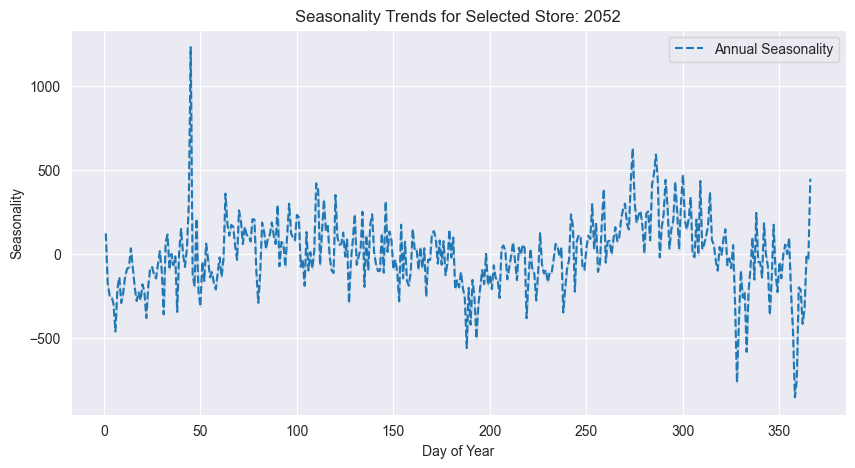

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(10, 5))

# Plot Weekly Seasonality
sns.lineplot(data=selected_stores, x="Day_of_Year", y="Annual_Seasonality_Avg", linestyle="dashed", label="Annual Seasonality")

# Plot Annual Seasonality
# sns.lineplot(data=selected_stores, x="Day_of_Year", y="Annual_Seasonality_Avg", label="Annual Seasonality")

plt.title("Seasonality Trends for Selected Store: "+str(stores[0]))
plt.xlabel("Day of Year")
plt.ylabel("Seasonality")
plt.legend()
plt.show()
plt.savefig("Seasonality Trends Day of Year.png", dpi=300)

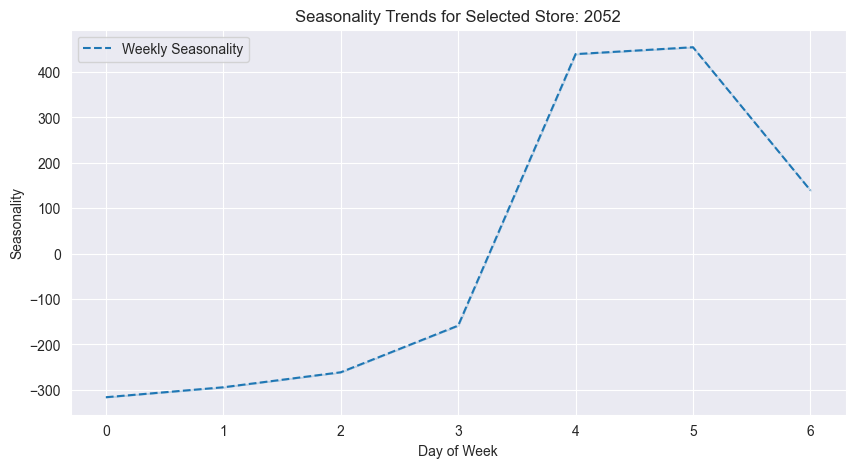

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(10, 5))

# Plot Weekly Seasonality
sns.lineplot(data=selected_stores, x="Day_of_Week", y="Weekly_Seasonality_Avg", linestyle="dashed", label="Weekly Seasonality")

# Plot Annual Seasonality
# sns.lineplot(data=selected_stores, x="Day_of_Year", y="Annual_Seasonality_Avg", label="Annual Seasonality")

plt.title("Seasonality Trends for Selected Store: "+str(stores[0]))
plt.xlabel("Day of Week")
plt.ylabel("Seasonality")
plt.legend()
plt.show()
plt.savefig("Seasonality Trends Day of Week.png", dpi=300)

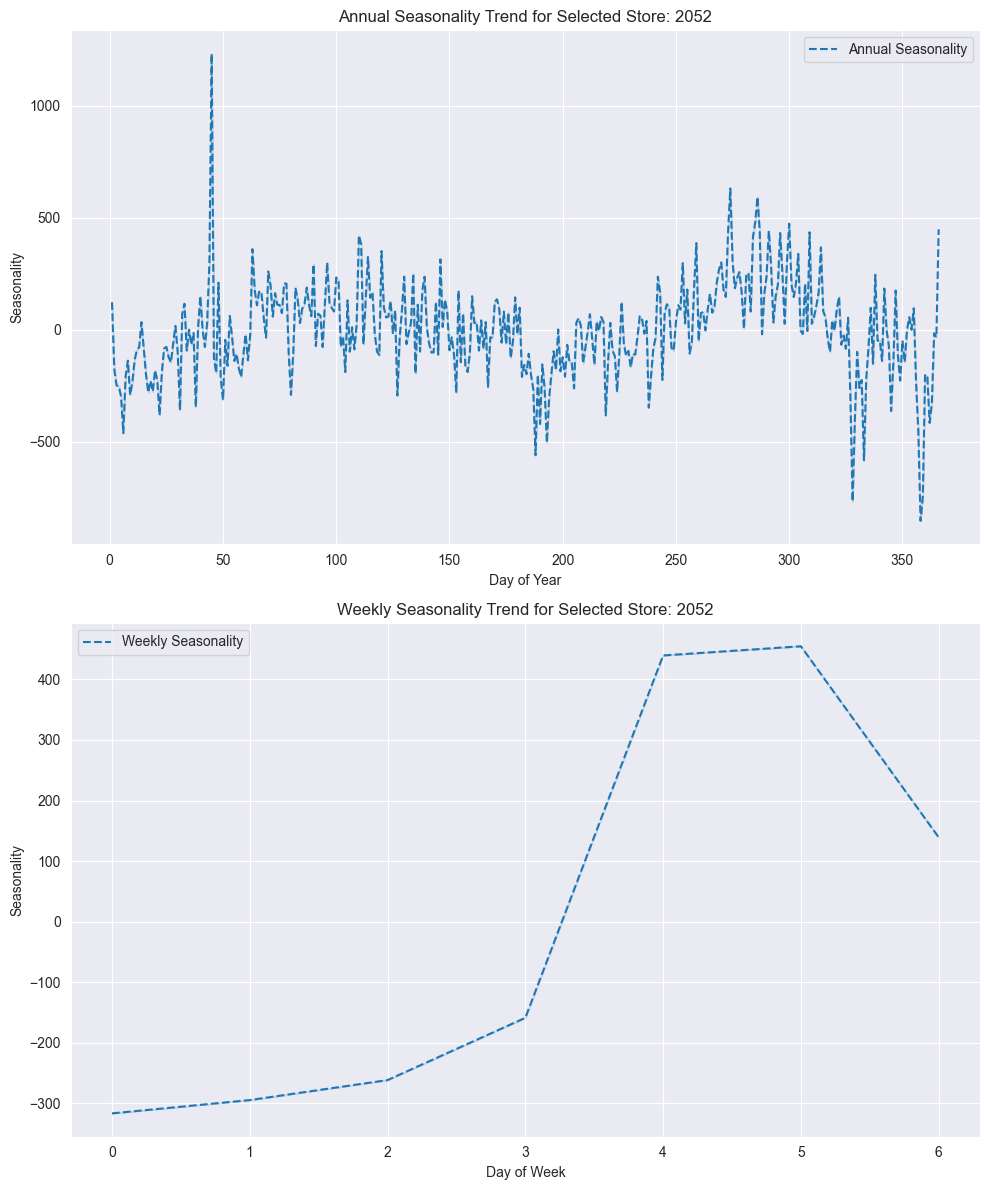

In [22]:
plt.figure(figsize=(10, 12))

# --- Plot 1: Annual Seasonality ---
plt.subplot(2, 1, 1)
sns.lineplot(data=selected_stores, x="Day_of_Year", y="Annual_Seasonality_Avg", linestyle="dashed", label="Annual Seasonality")
plt.title("Annual Seasonality Trend for Selected Store: " + str(stores[0]))
plt.xlabel("Day of Year")
plt.ylabel("Seasonality")
plt.legend()

# --- Plot 2: Weekly Seasonality ---
plt.subplot(2, 1, 2)
sns.lineplot(data=selected_stores, x="Day_of_Week", y="Weekly_Seasonality_Avg", linestyle="dashed", label="Weekly Seasonality")
plt.title("Weekly Seasonality Trend for Selected Store: " + str(stores[0]))
plt.xlabel("Day of Week")
plt.ylabel("Seasonality")
plt.legend()

plt.tight_layout()
plt.savefig("Combined_Seasonality_Trends.png", dpi=300)
plt.show()

In [ ]:
mstl[mstl['Store_ID']== 14]

In [97]:
selected_stores

,Day_of_Week,Weekly_Seasonality_Avg,Day_of_Year,Annual_Seasonality_Avg,Store_ID
23071,2,-261.499578,82,188.063577,2052
23072,3,-158.719289,83,134.870259,2052
23073,4,439.448105,84,30.621707,2052
23074,5,454.609279,85,95.915946,2052
23075,6,139.240953,86,116.434273,2052
...,...,...,...,...,...
24162,1,-294.509032,77,207.995192,2052
24163,2,-261.499578,78,206.515959,2052
24164,3,-158.719289,79,-101.310216,2052
24165,4,439.448105,80,-289.730614,2052
